In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/dataset_mu60_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_idx_sig = f["jet_ttbar_match"].array()
    jet_label_sig = np.ones(len(jet_pt_sig))

# Load background sample into memory
with uproot.open("ntuples/dataset_mu60_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_idx_bkg = f["jet_ttbar_match"].array()
    jet_label_bkg = np.zeros(len(jet_pt_bkg))

In [3]:
# crazy vectorized syntax https://awkward-array.org/doc/main/user-guide/how-to-restructure-concatenate.html#emulating-numpy-s-stack-functions
jet_sig = ak.concatenate([jet_pt_sig[:, :, np.newaxis], jet_eta_sig[:, :, np.newaxis], jet_phi_sig[:, :, np.newaxis], jet_m_sig[:, :, np.newaxis], jet_pufr_sig[:, :, np.newaxis]], axis=2)
jet_bkg = ak.concatenate([jet_pt_bkg[:, :, np.newaxis], jet_eta_bkg[:, :, np.newaxis], jet_phi_bkg[:, :, np.newaxis], jet_m_bkg[:, :, np.newaxis], jet_pufr_bkg[:, :, np.newaxis]], axis=2)

# combine sig and bkg into one vector
jet_feats = ak.concatenate([jet_sig, jet_bkg], axis=0)
jet_labels = np.concatenate([jet_label_sig,jet_label_bkg], axis=0)
jet_idx = np.array(ak.concatenate([jet_idx_sig, jet_idx_bkg], axis=0))

In [4]:
# Shuffle the features, labels, and selected idx
shuffled_idx = np.random.permutation(len(jet_feats))
jet_feats = jet_feats[shuffled_idx]
jet_labels = jet_labels[shuffled_idx]
jet_idx = jet_idx[shuffled_idx]

# Grab selected jets (more craxy syntax but I validated manually)
selected_jets = ak.to_numpy(jet_feats[jet_idx.tolist()])

# Get indicies of sig
sig = (jet_labels==1) 
bkg = ~sig

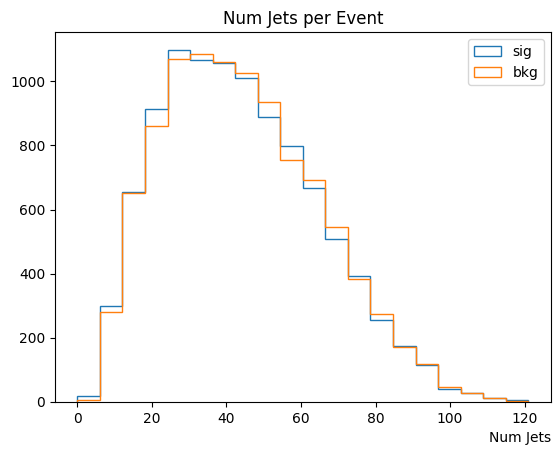

In [5]:
h_num_jets = ak.num(jet_feats,axis=1)
plt.title('Num Jets per Event')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=20,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=20,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

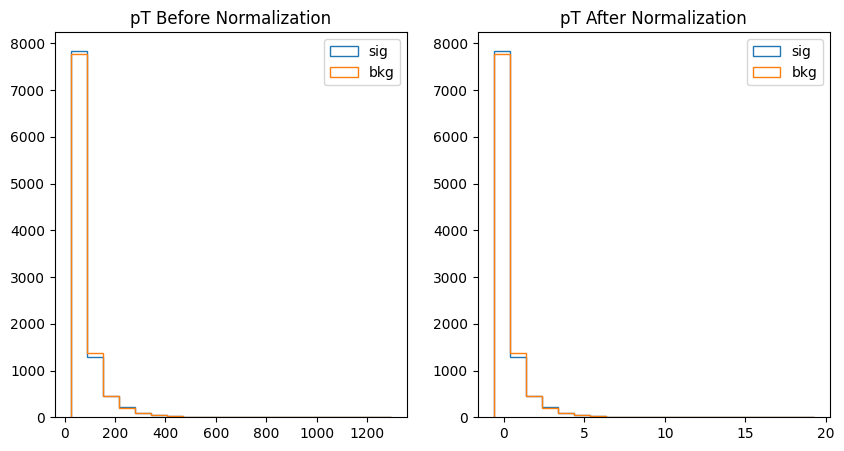

Before Mean:  65.64395238095238
Before STD:  63.84915475890267
After Mean:  2.9682522728329614e-05
After STD:  0.9999166627535923


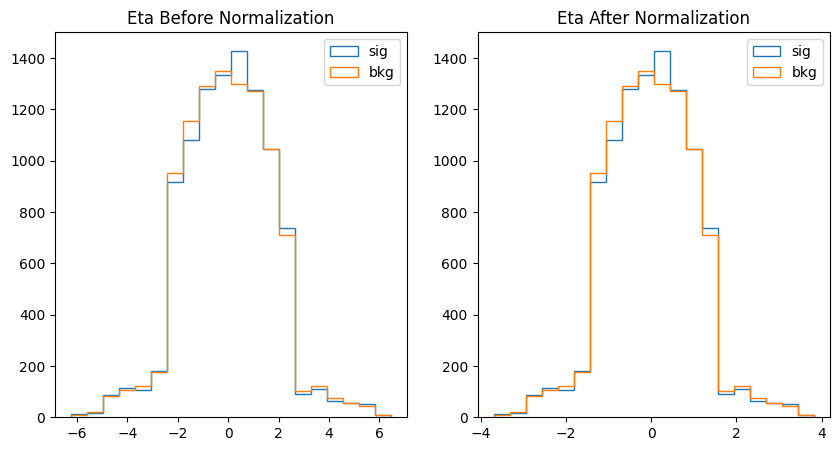

Before Mean:  0.011268339611235119
Before STD:  1.6894298587797871
After Mean:  -1.822624887738909e-08
After STD:  0.999999209449092


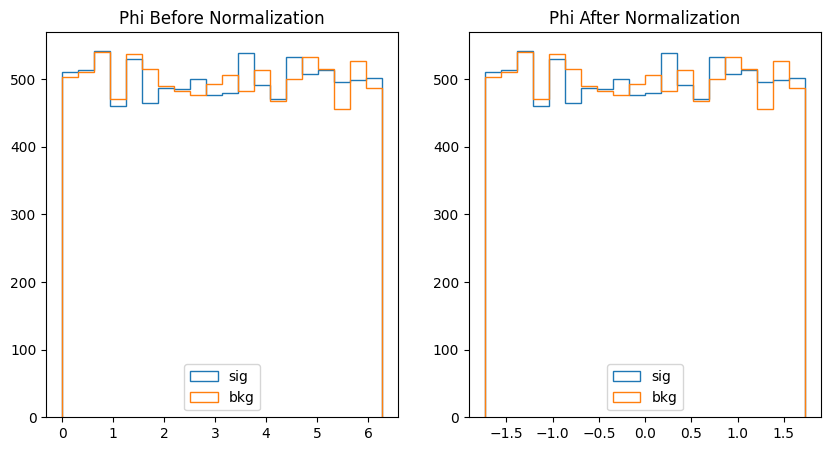

Before Mean:  3.1448683035714287
Before STD:  1.8152228535234094
After Mean:  1.2007455918050948e-06
After STD:  1.0000251112911334


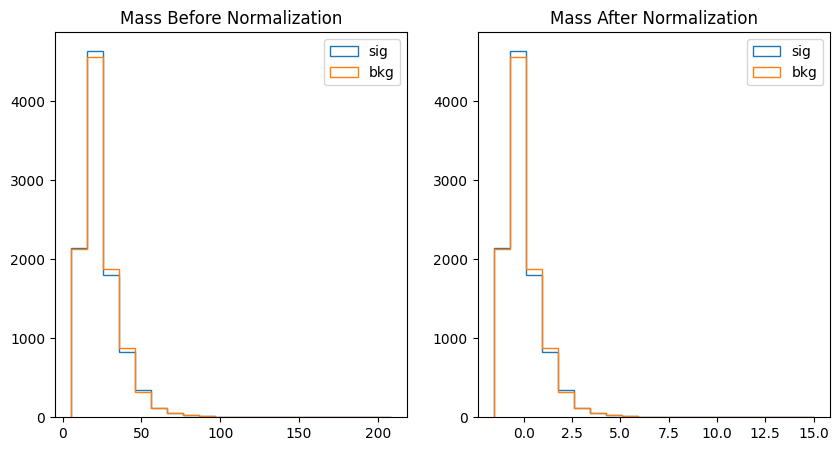

Before Mean:  24.31878125
Before STD:  12.260677462847712
After Mean:  9.551942348480225e-07
After STD:  0.9999760971841096


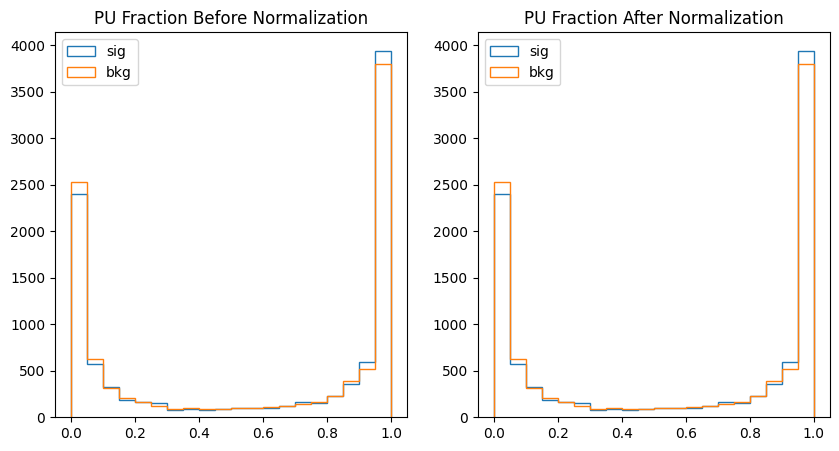

Before Mean:  0.5698543991815476
Before STD:  0.43225847642903087
After Mean:  0.5698543991815476
After STD:  0.43225847642903087


In [6]:
# Split dataset into train, val, test split
data = selected_jets
labels = jet_labels
num_events = len(data)
X_train_raw = data[0:int(0.7*num_events)]
y_train = labels[0:int(0.7*num_events)].reshape(-1,1)
X_val_raw = data[int(0.7*num_events):int(0.75*num_events)]
y_val = labels[int(0.7*num_events):int(0.75*num_events)].reshape(-1,1)
X_test_raw = data[int(0.75*num_events):]
y_test = labels[int(0.75*num_events):].reshape(-1,1)

# Calculate the mean and std of each feature
num_feats = len(jet_feats[0][0])
X_train_means = []
X_train_stds = []
for i in range(num_feats):
    X_train_means.append(ak.mean(X_train_raw[:,:,i]))
    X_train_stds.append(ak.std(X_train_raw[:,:,i]))
# Do not apply mean and std to pufr
X_train_means[-1]=0
X_train_stds[-1]=1

# Normalize dataset
X_train_norm = []
X_val_norm = []
X_test_norm = []
for i in range(num_feats):
    X_train_norm.append(ak.Array((X_train_raw[:,:,i] - X_train_means[i]) / X_train_stds[i])[:, :, np.newaxis])
    X_val_norm.append(ak.Array((X_val_raw[:,:,i] - X_train_means[i]) / X_train_stds[i])[:, :, np.newaxis])
    X_test_norm.append(ak.Array((X_test_raw[:,:,i] - X_train_means[i]) / X_train_stds[i])[:, :, np.newaxis])
X_train_norm = ak.concatenate(X_train_norm, axis=2)
X_val_norm = ak.concatenate(X_val_norm, axis=2)
X_test_norm = ak.concatenate(X_test_norm, axis=2)
        
# Validation plots
var_list = ['pT','Eta','Phi','Mass','PU Fraction']
for i in range(len(var_list)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = ak.flatten(X_train_raw[:,:,i])
    mini=ak.min(var1)
    maxi=ak.max(var1)
    ax1.hist(var1[sig],histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax1.hist(var1[bkg],histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    var2 = ak.flatten(X_train_norm[:,:,i])
    mini=ak.min(var2)
    maxi=ak.max(var2)
    ax2.hist(var2[sig],histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax2.hist(var2[bkg],histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

# Convert to torch.Tensor()
X_train = torch.Tensor(X_train_norm)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val_norm)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test_norm)
y_test = torch.Tensor(y_test)

In [7]:
class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_postprocess = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        jet_aggregated = jet_embedding.sum(dim=1)
        output = F.sigmoid(self.jet_postprocess(jet_aggregated))
        return output

In [8]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'test_loss':[]}

    for e in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train.to(device))
        loss = loss_fn(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

        model.eval()
        train_loss = loss.detach().cpu().numpy()
        history['train_loss'].append(train_loss)
        y_pred = model(X_val.to(device))
        test_loss = loss_fn(y_pred,y_val.to(device)).detach().cpu().numpy()
        history['test_loss'].append(test_loss)

        if (e+1)%1000==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))

    return history   

In [9]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Training Baseline
Epoch: 1000 	Train Loss: 0.6126 	Test Loss: 0.6023
Epoch: 2000 	Train Loss: 0.6128 	Test Loss: 0.5965
Epoch: 3000 	Train Loss: 0.6088 	Test Loss: 0.5943
Epoch: 4000 	Train Loss: 0.6061 	Test Loss: 0.5931
Epoch: 5000 	Train Loss: 0.6047 	Test Loss: 0.593
Epoch: 6000 	Train Loss: 0.6039 	Test Loss: 0.593
Epoch: 7000 	Train Loss: 0.6033 	Test Loss: 0.5927
Epoch: 8000 	Train Loss: 0.6026 	Test Loss: 0.5922
Epoch: 9000 	Train Loss: 0.6018 	Test Loss: 0.5917
Epoch: 10000 	Train Loss: 0.6011 	Test Loss: 0.5911

Training Proposed
Epoch: 1000 	Train Loss: 0.6183 	Test Loss: 0.6115
Epoch: 2000 	Train Loss: 0.6104 	Test Loss: 0.5964
Epoch: 3000 	Train Loss: 0.6075 	Test Loss: 0.5941
Epoch: 4000 	Train Loss: 0.6052 	Test Loss: 0.5924
Epoch: 5000 	Train Loss: 0.6033 	Test Loss: 0.5909
Epoch: 6000 	Train Loss: 0.602 	Test Loss: 0.59
Epoch: 7000 	Train Loss: 0.6013 	Test Loss: 0.5893
Epoch: 8000 	Train Loss: 0.6007 	Test Loss: 0.5887
Epoch: 9000 	Train Loss: 0.6 	Test Loss: 0.5879
E

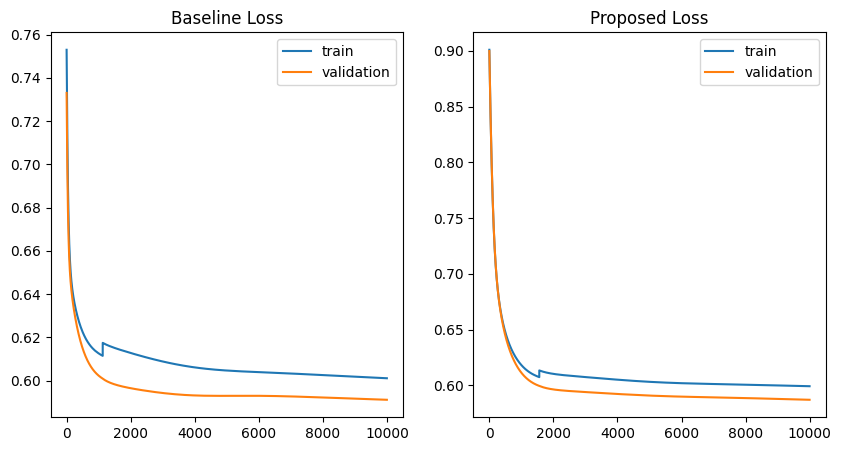

In [10]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

# Train baseline model with pt,eta,phi,m
print("Training Baseline")
baseline = Model(4,1024,1).to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.00001)
data = [X_train[:,:,0:4], y_train, X_val[:,:,0:4], y_val]
baseline_history = train(baseline, data, epochs=10000)
print()

# Train upgraded model with pt,eta,phi,m,pufr
print("Training Proposed")
model = Model(5,1024,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
data = [X_train, y_train, X_val, y_val]
model_history = train(model, data, epochs=10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_loss'],label='train')
ax1.plot(baseline_history['test_loss'],label='validation')
ax1.set_title("Baseline Loss")
ax1.legend()
ax2.plot(model_history['train_loss'],label='train')
ax2.plot(model_history['test_loss'],label='validation')
ax2.set_title("Proposed Loss")
ax2.legend()
plt.show()

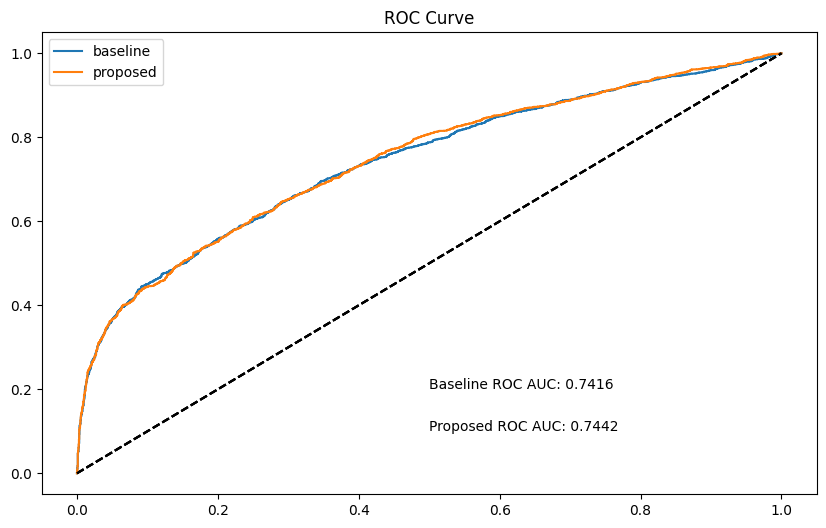

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
                             
baseline.to('cpu')
y_pred_baseline = baseline(X_test[:,:,0:4]).detach()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_baseline)
ax1.plot(fpr,tpr, label="baseline")
ax1.plot([[0,0],[1,1]],'--',color='k')
AUC = "Baseline ROC AUC: " + str(round(roc_auc_score(y_test, y_pred_baseline),4))
ax1.text(0.5,0.2,AUC)

model.to('cpu')
y_pred_proposed = model(X_test).detach()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proposed)
ax1.plot(fpr,tpr, label="proposed")
ax1.plot([[0,0],[1,1]],'--',color='k')
ax1.set_title("ROC Curve")
AUC = "Proposed ROC AUC: " + str(round(roc_auc_score(y_test, y_pred_proposed),4))
ax1.text(0.5,0.1,AUC)
ax1.legend()
plt.show()

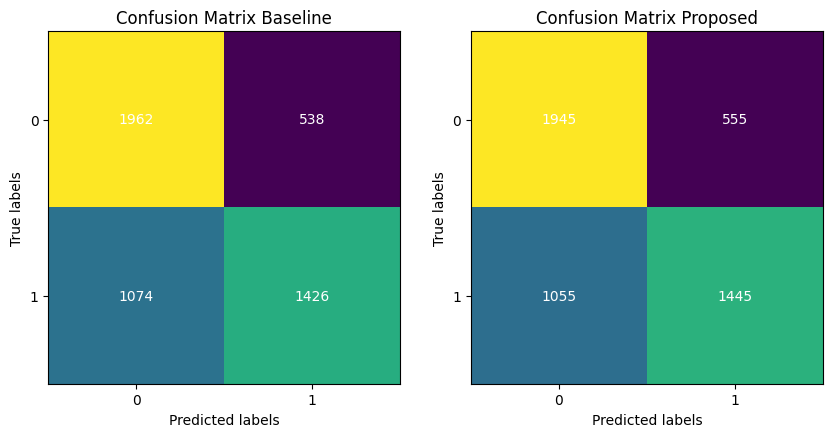

Binary Accuracy of Baseline:  0.6776
Binary Accuracy of Proposed:  0.678

F1 Score of Baseline:  0.6388888888888888
F1 Score of Proposed:  0.6422222222222222


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

threshold = 0.5

y_Pred_proposed = y_pred_proposed > threshold
y_Pred_baseline = y_pred_baseline > threshold

cm =confusion_matrix(y_test, y_Pred_baseline)
ax1.imshow(cm)
ax1.set_title("Confusion Matrix Baseline")
#ax1.set_colorbar()
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
for i in range(len(cm)):
    for j in range(len(cm)):
        ax1.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")

cm =confusion_matrix(y_test, y_Pred_proposed)
ax2.imshow(cm)
ax2.set_title("Confusion Matrix Proposed")
#ax2.colorbar()
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
for i in range(len(cm)):
    for j in range(len(cm)):
        ax2.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
plt.show()

print("Binary Accuracy of Baseline: ", accuracy_score(y_test, y_Pred_baseline))
print("Binary Accuracy of Proposed: ", accuracy_score(y_test, y_Pred_proposed))
print()
print("F1 Score of Baseline: ", f1_score(y_test, y_Pred_baseline))
print("F1 Score of Proposed: ", f1_score(y_test, y_Pred_proposed))